Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [2]:
NAME = "Jane Du"

---

In [3]:
# Import packages and define common functions. Do not modify.
import os
import numpy as np
import random
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image

import torch.optim as optim

%matplotlib inline
import matplotlib.pyplot as plt

def show_and_save(img, file_name):
    """Show and save the image.
    Args:
        img (Tensor): The image.
        file_name (Str): The destination.
    """
    npimg = np.transpose(img.numpy(), (1, 2, 0))
    f = "./%s.png" % file_name
    plt.imshow(npimg, cmap='gray')
    plt.show()
    plt.imsave(f, npimg)

def train(model, train_loader, n_epochs=20, lr=0.01):
    """Train a generative model.
    Args:
        model: The model.
        train_loader (DataLoader): The data loader.
        n_epochs (int, optional): The number of epochs. Defaults to 20.
        lr (Float, optional): The learning rate. Defaults to 0.01.
    Returns:
        The trained model.
    """
    train_op = optim.Adam(model.parameters(), lr)
    model.train()
    for epoch in tqdm(range(n_epochs)):
        loss_ = []
        for _, (data, target) in enumerate(train_loader):
            loss = model.get_loss(data.view(-1, 784))
            loss_.append(loss.item())
            train_op.zero_grad()
            loss.backward()
            train_op.step()
        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(loss_)))
    return model

def train_vae2(model, train_loader, n_epochs=20, lr=0.01):
    """Train a generative model.
    Args:
        model: The model.
        train_loader (DataLoader): The data loader.
        n_epochs (int, optional): The number of epochs. Defaults to 20.
        lr (Float, optional): The learning rate. Defaults to 0.01.
    Returns:
        The trained model.
    """
    train_op = optim.Adam(model.parameters(), lr)
    model.train()
    for epoch in tqdm(range(n_epochs)):
        loss_ = []
        for _, (data, target) in enumerate(train_loader):
            loss = model.get_loss(data)
            loss_.append(loss.item())
            train_op.zero_grad()
            loss.backward()
            train_op.step()
        print('Epoch %d\t Loss=%.4f' % (epoch, np.mean(loss_)))
    return model

seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# RBM

In [22]:
class RBM(nn.Module):
    """Restricted Boltzmann Machine.
    Args:
        n_vis (int, optional): The size of visible layer. Defaults to 784.
        n_hid (int, optional): The size of hidden layer. Defaults to 128.
        k (int, optional): The number of Gibbs sampling. Defaults to 1.
    """

    def __init__(self, n_vis=784, n_hid=128, k=1):
        """Create a RBM."""
        super(RBM, self).__init__()
        self.v = nn.Parameter(torch.randn(1, n_vis))
        self.h = nn.Parameter(torch.randn(1, n_hid))
        self.W = nn.Parameter(torch.randn(n_hid, n_vis))
        self.k = k

    def visible_to_hidden(self, v):
        r"""Conditional sampling a hidden variable given a visible variable.
        Args:
            v (Tensor): The visible variable.
        Returns:
            Tensor: The hidden variable.
        """
        p = torch.sigmoid(F.linear(v, self.W, self.h))
        return p.bernoulli()

    def hidden_to_visible(self, h):
        r"""Conditional sampling a visible variable given a hidden variable.
        Args:
            h (Tendor): The hidden variable.
        Returns:
            Tensor: The visible variable.
        """
        p = torch.sigmoid(F.linear(h, self.W.t(), self.v))
        return p.bernoulli()

    def free_energy(self, v, reduction="mean"):
        r"""Free energy function.
        .. math::
            \begin{align}
                F(x) &= -\log \sum_h \exp (-E(x, h)) \\
                &= -a^\top x - \sum_j \log (1 + \exp(W^{\top}_jx + b_j))\,.
            \end{align}
        Args:
            v (Tensor): The visible variable.
        Returns:
            energy (FloatTensor): The free energy value.
        """
        energy = -F.linear(v, self.v).sum(-1)
        energy -= F.softplus(F.linear(v, self.W, self.h)).sum(-1)
        if reduction == "none":
            return energy.squeeze(-1)
        elif reduction == "mean":
            return torch.mean(energy)

    def forward(self, v):
        r"""Compute the real and generated examples.
        Args:
            v (Tensor): The visible variable.
        Returns:
            (Tensor, Tensor): The real and generated variables.
        """
        v_gibb = v.clone()
        for _ in range(self.k):
            h = self.visible_to_hidden(v_gibb)
            v_gibb = self.hidden_to_visible(h)
        return v, v_gibb

    def get_loss(self, inputs):
        r"""Compute the loss for training the model.
        Args:
            inputs (Tensor): The visible variable.
        Returns:
            Tensor: Loss.
        """
        v, v_gibb = self(inputs)
        # print(v.shape)
        # print(v_gibb.shape)
        # print(inputs.shape)
        loss = self.free_energy(v) - self.free_energy(v_gibb)
        return loss

    @torch.no_grad()
    def pseudo_likelihood(self, v):
        """DO NOT MODIFY THIS FUNCTION"""
        # Randomly corrupt one feature in each sample in v.
        ind = (np.arange(v.shape[0]), np.random.randint(0, v.shape[1], v.shape[0]))
        v_ = v.clone()
        v_[ind] = 1 - v_[ind]
        fe = self.free_energy(v, reduction="none")
        fe_ = self.free_energy(v_, reduction="none")
        m = torch.nn.LogSigmoid()
        score = v.shape[1] * m(fe_ - fe)
        return score

In [23]:
# DO NOT MODIFY
train_dataset = datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), lambda x: (x > 0).float()]),
)
test_dataset = datasets.MNIST(
    "./data",
    train=False,
    transform=transforms.Compose([transforms.ToTensor(), lambda x: (x > 0).float()]),
)

batch_size = 128
n_hid = 128
n_vis = 784
n_epochs = 20
lr = 0.01
rbm_ckpt_fn = "model_rbm_seed2025.pt"

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [5]:
# You can try different k for the report, but use k=1 when submitting the checkpoint
# Do not modify other parts of this cell
if not os.path.exists(rbm_ckpt_fn):
    model_rbm = RBM(n_vis=n_vis, n_hid=n_hid, k=1)
    model_rbm = train(model_rbm, train_loader, n_epochs=n_epochs, lr=lr)
    # save model, do not change the filename.
    torch.save(model_rbm.state_dict(), rbm_ckpt_fn)

  0%|          | 0/20 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# You can use the following code to visualize reconstructed samples
# model_rbm = RBM(n_vis=n_vis, n_hid=n_hid, k=25)
# model_rbm = train(model_rbm, train_loader, n_epochs=n_epochs, lr=lr)

model_rbm.eval()

vis_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)

images = next(iter(vis_loader))[0]

v, v_gibbs = model_rbm(images.view(-1, 784))

show_and_save(make_grid(v_gibbs.view(64, 1, 28, 28).data), "rbm_fake")

  5%|▌         | 1/20 [00:30<09:35, 30.30s/it]

Epoch 0	 Loss=144.4315


  5%|▌         | 1/20 [00:54<17:14, 54.46s/it]


KeyboardInterrupt: 

# VAE

In [24]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        # Encoder
        self.enc_lin = nn.Linear(input_dim, hidden_dim)
        self.enc_mu = nn.Linear(hidden_dim, latent_dim)
        self.enc_sigma = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.dec_lin1 = nn.Linear(latent_dim, hidden_dim)
        self.dec_lin2 = nn.Linear(hidden_dim, input_dim)

    def encoding(self, x):
        """Encode inputs x.
        Args:
            x (Tensor): Inputs. Take Tanh as the enc_lin layer's non-linear activation function.
        Returns:
            (z_mu, z_sigma): Mean and log variance of latent variables z.
        """
        # YOUR CODE HERE
        z_mu = self.enc_mu(torch.tanh(self.enc_lin(x)))
        z_sigma = self.enc_sigma(torch.tanh(self.enc_lin(x)))
        return z_mu, z_sigma

    def decoding(self, z):
        """Decode latent variable z into reconstructed data.
        Two linear layers with Tanh as the middle layer's act func and Sigmoid as the output layer's act func.
        Args:
            z (Tensor): Inputs.
        Returns:
            x_hat: Reconstructed inputs.
        """
        # YOUR CODE HERE
        z = torch.tanh(self.dec_lin1(z))
        z = F.sigmoid(self.dec_lin2(z))
        return z

    def forward(self, x):
        """Compute reconstructed inputs.
        Args:
            x (Tensor): Inputs.
        Returns:
            (x_hat, z_mu, z_sigma): Reconstructed inputs, mean and log variance of latent variables.
        """
        # YOUR CODE HERE
        z_mu, z_sigma = self.encoding(x)
        z = z_mu + torch.randn_like(z_sigma) * torch.exp(0.5 * z_sigma)
        x_hat = self.decoding(z)
        return x_hat, z_mu, z_sigma

    def get_loss(self, x):
        """Compute VAE loss.
        Args:
            x (Tensor): Inputs.
        Returns:
            loss (FloatTensor): reconstruction loss + KL loss
        """
        x_hat, z_mu, z_sigma = self(x)
        reconstruction_loss = F.mse_loss(x_hat, x, reduction='sum')
        kl_loss = -0.5 * torch.sum(1 + z_sigma - z_mu.pow(2) - torch.exp(z_sigma))
        return reconstruction_loss + kl_loss

    @torch.no_grad()
    def sample(self, n_samples, device):
        random_z = torch.randn(n_samples, self.latent_dim).to(device)
        x_hat = self.decoding(random_z)
        return x_hat

In [25]:
# DO NOT MODIFY
train_dataset = datasets.MNIST(
    "./data", train=True, transform=transforms.Compose([transforms.ToTensor()])
)
test_dataset = datasets.MNIST(
    "./data", train=False, transform=transforms.Compose([transforms.ToTensor()])
)

batch_size = 128
input_dim = 784
hidden_dim = 500
n_epochs = 40
lr = 0.001
vae_ckpt_fn = "model_vae_seed2025.pt"

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [26]:
# You can try different latent_dim for the report, but use latent_dim=20 when submitting the checkpoint
# Do not modify other parts of this cell
if not os.path.exists(vae_ckpt_fn):
    model_vae = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=20)
    model_vae = train(model_vae, train_loader, n_epochs=n_epochs, lr=lr)
    # save model, do not change the filename.
    torch.save(model_vae.state_dict(), vae_ckpt_fn)

  2%|▎         | 1/40 [00:06<04:32,  6.98s/it]

Epoch 0	 Loss=6216.9770


  5%|▌         | 2/40 [00:13<04:22,  6.91s/it]

Epoch 1	 Loss=5504.8156


  8%|▊         | 3/40 [00:20<04:14,  6.87s/it]

Epoch 2	 Loss=5321.5395


 10%|█         | 4/40 [00:27<04:12,  7.01s/it]

Epoch 3	 Loss=5229.9919


 12%|█▎        | 5/40 [00:35<04:13,  7.23s/it]

Epoch 4	 Loss=5160.2465


 15%|█▌        | 6/40 [00:42<04:06,  7.26s/it]

Epoch 5	 Loss=5106.3524


 18%|█▊        | 7/40 [00:49<03:55,  7.15s/it]

Epoch 6	 Loss=5061.8807


 20%|██        | 8/40 [00:56<03:47,  7.11s/it]

Epoch 7	 Loss=5023.1585


 22%|██▎       | 9/40 [01:03<03:38,  7.06s/it]

Epoch 8	 Loss=4990.9775


 25%|██▌       | 10/40 [01:10<03:31,  7.04s/it]

Epoch 9	 Loss=4962.6853


 28%|██▊       | 11/40 [01:17<03:25,  7.09s/it]

Epoch 10	 Loss=4934.4916


 30%|███       | 12/40 [01:25<03:20,  7.17s/it]

Epoch 11	 Loss=4912.0761


 32%|███▎      | 13/40 [01:32<03:11,  7.08s/it]

Epoch 12	 Loss=4892.6284


 35%|███▌      | 14/40 [01:38<03:02,  7.01s/it]

Epoch 13	 Loss=4868.2380


 38%|███▊      | 15/40 [01:45<02:55,  7.01s/it]

Epoch 14	 Loss=4849.6761


 40%|████      | 16/40 [01:53<02:52,  7.17s/it]

Epoch 15	 Loss=4831.9402


 42%|████▎     | 17/40 [02:00<02:44,  7.17s/it]

Epoch 16	 Loss=4814.8712


 45%|████▌     | 18/40 [02:07<02:36,  7.13s/it]

Epoch 17	 Loss=4800.3761


 48%|████▊     | 19/40 [02:14<02:29,  7.13s/it]

Epoch 18	 Loss=4783.5740


 50%|█████     | 20/40 [02:22<02:25,  7.29s/it]

Epoch 19	 Loss=4773.8429


 52%|█████▎    | 21/40 [02:29<02:18,  7.28s/it]

Epoch 20	 Loss=4760.4842


 55%|█████▌    | 22/40 [02:37<02:11,  7.31s/it]

Epoch 21	 Loss=4747.1361


 57%|█████▊    | 23/40 [02:45<02:07,  7.50s/it]

Epoch 22	 Loss=4732.9323


 60%|██████    | 24/40 [02:52<01:58,  7.39s/it]

Epoch 23	 Loss=4721.9967


 62%|██████▎   | 25/40 [02:59<01:49,  7.31s/it]

Epoch 24	 Loss=4710.5219


 65%|██████▌   | 26/40 [03:06<01:41,  7.24s/it]

Epoch 25	 Loss=4700.3512


 68%|██████▊   | 27/40 [03:13<01:33,  7.19s/it]

Epoch 26	 Loss=4693.9948


 70%|███████   | 28/40 [03:20<01:27,  7.27s/it]

Epoch 27	 Loss=4682.8873


 72%|███████▎  | 29/40 [03:28<01:19,  7.21s/it]

Epoch 28	 Loss=4673.3048


 75%|███████▌  | 30/40 [03:35<01:11,  7.17s/it]

Epoch 29	 Loss=4666.0443


 78%|███████▊  | 31/40 [03:42<01:03,  7.11s/it]

Epoch 30	 Loss=4661.4517


 80%|████████  | 32/40 [03:49<00:57,  7.14s/it]

Epoch 31	 Loss=4656.1434


 82%|████████▎ | 33/40 [03:57<00:51,  7.42s/it]

Epoch 32	 Loss=4643.0076


 85%|████████▌ | 34/40 [04:05<00:44,  7.49s/it]

Epoch 33	 Loss=4636.7183


 88%|████████▊ | 35/40 [04:13<00:38,  7.67s/it]

Epoch 34	 Loss=4630.8833


 90%|█████████ | 36/40 [04:20<00:30,  7.71s/it]

Epoch 35	 Loss=4624.9289


 92%|█████████▎| 37/40 [04:29<00:23,  7.85s/it]

Epoch 36	 Loss=4622.0850


 95%|█████████▌| 38/40 [04:37<00:16,  8.06s/it]

Epoch 37	 Loss=4615.8378


 98%|█████████▊| 39/40 [04:45<00:08,  8.12s/it]

Epoch 38	 Loss=4604.2771


100%|██████████| 40/40 [04:53<00:00,  7.34s/it]

Epoch 39	 Loss=4598.7002


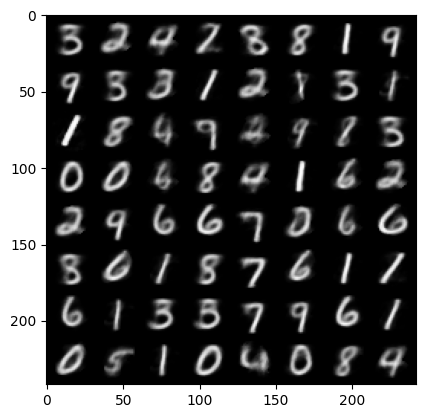

In [11]:
model_vae = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=2)
model_vae = train(model_vae, train_loader, n_epochs=n_epochs, lr=lr)
# You can use the following code to visualize generated samples

model_vae.eval()
x_hat = model_vae.sample(64, "cpu")
# x_hat = x_hat.bernoulli()
show_and_save(make_grid(x_hat.view(64, 1, 28, 28).data.cpu()), "vae_fake")

# VAE2

In [4]:
class VAE2(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encd = 8 * 3 * 3
        self.decd = 8 * 3 * 3

        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)
        self.conv3 = nn.Conv2d(8, 8, 3, padding=1)
        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.enc_mu = nn.Linear(self.encd, self.latent_dim)
        self.enc_sigma = nn.Linear(self.encd, self.latent_dim)

        self.dec_fc = nn.Linear(self.latent_dim, self.decd)
        self.deconv1 = nn.ConvTranspose2d(8, 8, 2, stride=2, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d( 8, 8,2,stride=2, )
        self.deconv3 = nn.ConvTranspose2d(
            8,
            8,
            2,
            stride=2,
        )
        self.dec_conv = nn.Conv2d(8, 1, 3, padding=1)

    def encoding(self, x):
        """Encode inputs x.
        Args:
            x (Tensor): Inputs. Take Tanh as the enc_lin layer's non-linear activation function.
        Returns:
            (z_mu, z_sigma): Mean and log variance of latent variables z.
        """
        x = self.maxpool(F.relu(self.conv1(x)))
        x = self.maxpool(F.relu(self.conv2(x)))
        x = self.maxpool(F.relu(self.conv3(x)))
        z_mu = self.enc_mu(x.view(-1, self.encd))
        z_sigma = self.enc_sigma(x.view(-1, self.encd))
        return z_mu, z_sigma

    def decoding(self, z):
        """Decode latent variable z into reconstructed data.
        Two linear layers with Tanh as the middle layer's act func and Sigmoid as the output layer's act func.
        Args:
            z (Tensor): Inputs.
        Returns:
            x_hat: Reconstructed inputs.
        """
        z = self.dec_fc(z).view(-1, 8, 3, 3)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        z = F.relu(self.deconv3(z))
        x_hat = torch.sigmoid(self.dec_conv(z))

        return x_hat

    def forward(self, x):
        """Compute reconstructed inputs.
        Args:
            x (Tensor): Inputs.
        Returns:
            (x_hat, z_mu, z_sigma): Reconstructed inputs, mean and log variance of latent variables.
        """
        # YOUR CODE HERE
        z_mu, z_sigma = self.encoding(x)
        z = z_mu + torch.randn_like(z_sigma) * torch.exp(0.5 * z_sigma)
        x_hat = self.decoding(z)
        return x_hat, z_mu, z_sigma

    def get_loss(self, x):
        """Compute VAE loss.
        Args:
            x (Tensor): Inputs.
        Returns:
            loss (FloatTensor): reconstruction loss + KL loss
        """
        x_hat, z_mu, z_sigma = self(x)
        reconstruction_loss = F.mse_loss(x_hat, x, reduction="sum")
        kl_loss = -0.5 * torch.sum(1 + z_sigma - z_mu.pow(2) - torch.exp(z_sigma))
        return reconstruction_loss + kl_loss

    @torch.no_grad()
    def sample(self, n_samples, device):
        random_z = torch.randn(n_samples, self.latent_dim).to(device)
        x_hat = self.decoding(random_z)
        return x_hat

In [5]:
# DO NOT MODIFY
train_dataset = datasets.MNIST(
    "./data", train=True, transform=transforms.Compose([transforms.ToTensor()])
)
test_dataset = datasets.MNIST(
    "./data", train=False, transform=transforms.Compose([transforms.ToTensor()])
)

batch_size = 128
n_epochs = 40
lr = 0.005
vae_ckpt_fn = "model_vae2_seed2025.pt"

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [17]:
# You can try different latent_dim for the report, but use latent_dim=20 when submitting the checkpoint
# Do not modify other parts of this cell
if not os.path.exists(vae_ckpt_fn):
    model_vae = VAE2(latent_dim=20)
    model_vae = train_vae2(model_vae, train_loader, n_epochs=n_epochs, lr=lr)
    # save model, do not change the filename.
    torch.save(model_vae.state_dict(), vae_ckpt_fn)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

  2%|▎         | 1/40 [00:23<14:57, 23.02s/it]

Epoch 0	 Loss=6695.8374


  5%|▌         | 2/40 [00:46<14:50, 23.43s/it]

Epoch 1	 Loss=4992.0066


  8%|▊         | 3/40 [01:10<14:37, 23.73s/it]

Epoch 2	 Loss=4848.0842


 10%|█         | 4/40 [01:35<14:26, 24.06s/it]

Epoch 3	 Loss=4781.6684


 12%|█▎        | 5/40 [02:03<14:54, 25.57s/it]

Epoch 4	 Loss=4742.5933


 15%|█▌        | 6/40 [02:27<14:12, 25.06s/it]

Epoch 5	 Loss=4715.8530


 18%|█▊        | 7/40 [02:50<13:26, 24.45s/it]

Epoch 6	 Loss=4690.5593


 20%|██        | 8/40 [03:14<12:51, 24.11s/it]

Epoch 7	 Loss=4677.7933


 22%|██▎       | 9/40 [03:38<12:24, 24.01s/it]

Epoch 8	 Loss=4657.8720


 25%|██▌       | 10/40 [04:01<11:56, 23.87s/it]

Epoch 9	 Loss=4648.6748


 28%|██▊       | 11/40 [04:25<11:32, 23.88s/it]

Epoch 10	 Loss=4633.7095


 30%|███       | 12/40 [04:48<11:04, 23.72s/it]

Epoch 11	 Loss=4623.6506


 32%|███▎      | 13/40 [05:11<10:35, 23.53s/it]

Epoch 12	 Loss=4609.4929


 35%|███▌      | 14/40 [05:35<10:11, 23.54s/it]

Epoch 13	 Loss=4609.8263


 38%|███▊      | 15/40 [05:58<09:44, 23.38s/it]

Epoch 14	 Loss=4600.2546


 40%|████      | 16/40 [06:22<09:22, 23.44s/it]

Epoch 15	 Loss=4590.9919


 42%|████▎     | 17/40 [06:45<08:58, 23.40s/it]

Epoch 16	 Loss=4587.9433


 45%|████▌     | 18/40 [07:08<08:32, 23.30s/it]

Epoch 17	 Loss=4584.8760


 48%|████▊     | 19/40 [07:31<08:08, 23.24s/it]

Epoch 18	 Loss=4576.6888


 50%|█████     | 20/40 [07:55<07:48, 23.45s/it]

Epoch 19	 Loss=4575.9250


 52%|█████▎    | 21/40 [08:20<07:36, 24.02s/it]

Epoch 20	 Loss=4569.4161


 55%|█████▌    | 22/40 [08:44<07:07, 23.76s/it]

Epoch 21	 Loss=4565.3136


 57%|█████▊    | 23/40 [09:07<06:40, 23.58s/it]

Epoch 22	 Loss=4560.0101


 60%|██████    | 24/40 [09:31<06:19, 23.72s/it]

Epoch 23	 Loss=4559.2236


 62%|██████▎   | 25/40 [09:55<05:57, 23.82s/it]

Epoch 24	 Loss=4560.4615


 65%|██████▌   | 26/40 [10:20<05:37, 24.12s/it]

Epoch 25	 Loss=4548.6258


 68%|██████▊   | 27/40 [10:45<05:17, 24.44s/it]

Epoch 26	 Loss=4548.3270


 70%|███████   | 28/40 [11:09<04:53, 24.45s/it]

Epoch 27	 Loss=4549.0230


 72%|███████▎  | 29/40 [11:38<04:43, 25.81s/it]

Epoch 28	 Loss=4553.1175


 75%|███████▌  | 30/40 [12:05<04:22, 26.24s/it]

Epoch 29	 Loss=4543.7691


 78%|███████▊  | 31/40 [12:30<03:52, 25.83s/it]

Epoch 30	 Loss=4542.7317


 80%|████████  | 32/40 [12:55<03:24, 25.51s/it]

Epoch 31	 Loss=4542.5320


 82%|████████▎ | 33/40 [13:19<02:55, 25.13s/it]

Epoch 32	 Loss=4544.0853


 85%|████████▌ | 34/40 [13:43<02:28, 24.77s/it]

Epoch 33	 Loss=4536.3548


 88%|████████▊ | 35/40 [14:07<02:02, 24.60s/it]

Epoch 34	 Loss=4535.6144


 90%|█████████ | 36/40 [14:32<01:38, 24.51s/it]

Epoch 35	 Loss=4536.2806


 92%|█████████▎| 37/40 [14:56<01:12, 24.28s/it]

Epoch 36	 Loss=4536.4306


 95%|█████████▌| 38/40 [15:21<00:49, 24.57s/it]

Epoch 37	 Loss=4532.5435


 98%|█████████▊| 39/40 [15:45<00:24, 24.48s/it]

Epoch 38	 Loss=4524.8250


100%|██████████| 40/40 [16:10<00:00, 24.25s/it]

Epoch 39	 Loss=4528.6368


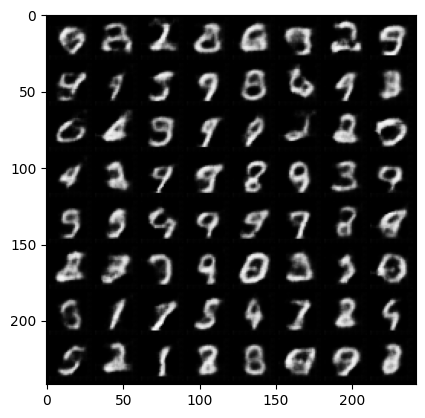

In [15]:
model_vae = VAE2(latent_dim=20)
model_vae = train_vae2(model_vae, train_loader, n_epochs=n_epochs, lr=lr)
# You can use the following code to visualize generated samples
model_vae.eval()
x_hat = model_vae.sample(64, "cpu")
# x_hat = x_hat.bernoulli()
show_and_save(make_grid(x_hat.view(64, 1, 28, 28).data.cpu()), "vae_fake")

In [13]:
model_vae = VAE2(latent_dim=20)

In [14]:
model_vae.state_dict()['conv1.weight']

tensor([[[[ 0.2207, -0.1437, -0.1115],
          [ 0.2286,  0.2174,  0.1250],
          [-0.0213, -0.1251,  0.0919]]],


        [[[ 0.1355,  0.2624, -0.2731],
          [ 0.0403, -0.0130,  0.0057],
          [-0.2036, -0.1503,  0.1508]]],


        [[[ 0.2400, -0.2542,  0.2645],
          [-0.1514, -0.1807,  0.1777],
          [-0.3063,  0.2556, -0.1796]]],


        [[[ 0.1916,  0.0426,  0.2348],
          [-0.2841, -0.2932, -0.1923],
          [ 0.0922,  0.2044, -0.3144]]],


        [[[-0.0760,  0.2765, -0.2750],
          [ 0.0950, -0.1041, -0.0370],
          [-0.0046, -0.2314, -0.2452]]],


        [[[-0.2904, -0.2546, -0.2820],
          [-0.2564,  0.2952, -0.0361],
          [-0.0533, -0.2053,  0.0285]]],


        [[[-0.1085,  0.2267,  0.2028],
          [-0.3057,  0.1822, -0.1253],
          [ 0.1490, -0.2185, -0.2877]]],


        [[[-0.3247,  0.3280, -0.2789],
          [-0.1785, -0.0114, -0.0126],
          [ 0.0889,  0.1844,  0.1515]]]])